# Phoenix 项目 - 交互式训练与分析控制台

**版本: 3.2 (Keyword驱动最终版)**

本 Notebook 是整个模型构建工作流的**交互式主控台**。它允许您直接在 Notebook 中配置超参数、触发训练、监控进度，并以可视化的方式评估最终结果。

### 核心功能:
1.  **加载配置**: 读取 `config.json` 获取基础股票列表和设置。
2.  **交互式超参数配置**: 在专门的单元格中定义用于本次训练的超参数。
3.  **数据预处理**: 调用 `save_data.py` 确保所有特征数据准备就绪。
4.  **模型训练与监控**: **通过传递 `keyword`** (e.g., "贵州茅台") 作为唯一标识符来调用 `build_models.py`，彻底解决了路径不匹配问题。训练过程将显示**总体进度条**和**实时日志**。
5.  **可视化评估**: 训练结束后，自动加载所有模型的 Walk-Forward 验证结果，并通过**图表和表格**进行直观的性能对比。

## 1. 环境设置与配置加载

In [1]:
# 1.1 安装依赖库
# %pip install pandas numpy lightgbm joblib scikit-learn matplotlib seaborn tqdm -q

# 1.2 导入所需模块
import sys, json,warnings, importlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')

import get_data, save_data, build_models
importlib.reload(get_data)
importlib.reload(save_data)
importlib.reload(build_models)
print("自定义模块导入并加载成功。")

# 设置图表样式
sns.set_style("whitegrid")
plt.rcParams['font.sans-serif'] = ['SimHei'] # 解决中文显示问题
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

print("环境设置与库导入完成。")

自定义模块导入并加载成功。
环境设置与库导入完成。


## 2. 交互式超参数配置

**在此处调整参数以进行模型实验。** 这些设置将通过命令行传递给 `build_models.py`，从而覆盖其内部的默认值或 `config.json` 中的设置。

In [ ]:
CONFIG_FILE_PATH = 'config.json'

try:
    with open(CONFIG_FILE_PATH, 'r', encoding='utf-8') as f:
        config = json.load(f)
    print(f"SUCCESS: 基础配置文件 '{CONFIG_FILE_PATH}' 加载成功。")
except FileNotFoundError:
    print(f"ERROR: 未找到配置文件 '{CONFIG_FILE_PATH}'。请确保文件存在于当前目录。")
    config = {}

training_hyperparams = {
    "walk_forward_splits": 5,          # Walk-forward 交叉验证总折数。模型将被训练和评估5次，每次都在一个滚动的时间窗口上。
    "train_ratio_per_split": 0.60,     # 每一折中，用于初始训练集的数据占比。较小的值为滚动留出更多空间。
    "validation_ratio_per_split": 0.15,# 每一折中，紧跟在训练集后面的验证集数据占比。用于早停和评估。
    "embargo_days": 5,                 # 训练集和验证集之间的隔离期（天数）。用于防止信息泄露，使验证更接近真实交易场景。

    "num_final_features": 30,          # 最终筛选后用于模型训练的特征数量。这是控制模型复杂度的关键参数之一，较小的值有助于防止过拟合。

    "labeling_horizon": 30,            # 模型预测天数
    "n_estimators": 1000000,           # 总迭代轮数（弱学习器/树的最大数量）。实际训练轮数通常由 early_stopping_rounds 决定。
    "learning_rate": 0.01,             # 学习率。决定了模型每次迭代的步长。较小的值使学习过程更慢、更稳定，有助于找到更优的解并防止过拟合。
    "num_leaves": 10,                  # 每棵树的最大叶子节点数。这是控制单棵树复杂度的核心参数。对于噪声大的金融数据，较小的值（如7-15）通常表现更好。
    "min_child_samples": 20,           # 一个叶子节点上所需的最小样本数。可以防止模型学习过于局部的、由少数样本构成的模式，是重要的正则化手段。
    "early_stopping_rounds": 50000,      # 早停轮数。如果在验证集上的性能连续这么多轮没有提升，训练将自动停止。这是防止过拟合的关键。

    "feature_fraction": 0.8,           # 特征采样比例。在构建每棵树时，随机选择80%的特征进行训练。可以减少特征之间的共线性影响。
    "bagging_fraction": 0.8,           # 数据采样比例（行采样）。在每次迭代时，随机选择80%的数据来训练，可以防止模型对少数异常值过于敏感。
    "bagging_freq": 1,                 # 数据采样的频率。设置为1表示每次迭代都进行数据采样。
    "reg_alpha": 0.1,                  # L1 正则化系数。有助于使一些不重要特征的权重变为0，有特征选择的效果。
    "reg_lambda": 0.1,                 # L2 正则化系数。惩罚过大的模型权重，使模型更平滑。

    "device": "gpu",                   # 指定训练设备。'gpu' 或 'cpu'。
    "force_retrain": True,             # 是否强制重新训练已存在的模型。在调参时应设为 True。
    "log_evaluation_period": 500       # 训练过程中打印验证集损失的周期。每训练200轮输出一次日志。
}

print("SUCCESS: 本次运行的超参数已定义。")

if config:
    # 检查 'global_settings' 是否存在
    if 'global_settings' not in config:
        config['global_settings'] = {}

    # 检查并补全缺失的键
    if 'raw_ohlcv_cache_dir' not in config['global_settings']:
        print("WARNNING: 'raw_ohlcv_cache_dir' 在 config.json 中缺失，动态添加默认值 'raw_ohlcv'...")
        config['global_settings']['raw_ohlcv_cache_dir'] = 'raw_ohlcv'
        
        # 将修复后的配置写回文件，供下游模块使用
        with open(CONFIG_FILE_PATH, 'w', encoding='utf-8') as f:
            json.dump(config, f, indent=4, ensure_ascii=False)
        print(f"SUCCESS: 配置文件 '{CONFIG_FILE_PATH}' 已动态更新。")
    else:
        print("SUCCESS: 配置文件包含所有必需的键，无需修复。")

SUCCESS: 基础配置文件 'config.json' 加载成功。
SUCCESS: 本次运行的超参数已定义。
SUCCESS: 配置文件包含所有必需的键，无需修复。


## 3. 数据预处理

运行 `save_data.py` 脚本，确保所有股票的特征数据都已生成。该脚本内置断点逻辑，已存在的数据不会重复处理。

In [3]:
if 'save_data' in sys.modules:
    print("\n开始执行数据准备管道...")
    save_data.run_data_pipeline(config_path=CONFIG_FILE_PATH)
    print("\nSUCCESS: 数据准备管道执行完毕。")
else:
    print("ERROR: 数据准备模块 (save_data) 未成功加载，跳过此步骤。")


开始执行数据准备管道...
开始执行数据管道协调任务...
将使用配置文件: config.json
login success!
INFO: Baostock API 登录成功。SDK版本: 00.8.90
INFO: Tushare Pro API 初始化成功。将尝试获取宏观数据。

(1/7) 正在处理股票: 601606.SH...
INFO: 从L2缓存加载 sh.601606 的最终特征数据...

(2/7) 正在处理股票: 603099.SH...
INFO: 从L2缓存加载 sh.603099 的最终特征数据...

(3/7) 正在处理股票: 000681.SZ...
INFO: 从L2缓存加载 sz.000681 的最终特征数据...

(4/7) 正在处理股票: 600519.SH...
INFO: 从L2缓存加载 sh.600519 的最终特征数据...

(5/7) 正在处理股票: 000001.SZ...
INFO: 从L2缓存加载 sz.000001 的最终特征数据...

(6/7) 正在处理股票: 688256.SH...
INFO: 从L2缓存加载 sh.688256 的最终特征数据...

(7/7) 正在处理股票: 000100.SZ...
INFO: 从L2缓存加载 sz.000100 的最终特征数据...
logout success!

所有股票处理完毕，Baostock 已登出。

开始以确定性方式保存处理好的数据...
  - INFO: 数据文件已存在于 data\processed\601606.SH\2000-01-01_to_2024-12-31\features_17bca02bee.pkl，跳过保存 601606.SH。
  - INFO: 数据文件已存在于 data\processed\603099.SH\2000-01-01_to_2024-12-31\features_17bca02bee.pkl，跳过保存 603099.SH。
  - INFO: 数据文件已存在于 data\processed\000681.SZ\2000-01-01_to_2024-12-31\features_17bca02bee.pkl，跳过保存 000681.SZ。
  - INFO: 数据文件已存在于 data\pr

## 4. 模型训练与监控

现在，我们将带着配置好的超参数，为每只股票启动模型训练流程。下面的进度条展示了**总体进度**，每个股票的**详细训练日志**会实时输出。

In [4]:
if 'build_models' in sys.modules and config:
    global_settings = config.get('global_settings', {})
    stocks_to_process = config.get('stocks_to_process', [])
    OUTPUT_MODEL_DIR = Path(global_settings.get('model_dir', 'models'))

    if not stocks_to_process:
        print("ERROR: 配置文件中没有找到需要处理的股票，训练终止。")
    else:
        print("="*80)
        print("开始批量模型构建...")
        print("="*80)
        
        for stock_config in tqdm(stocks_to_process, desc="总体进度"):
            ticker = stock_config.get("ticker")
            keyword = stock_config.get("keyword", ticker)
            
            tqdm.write(f"\n--- 正在处理: {keyword} ({ticker}) ---")
            
            # 断点续训逻辑
            model_exists = any((OUTPUT_MODEL_DIR / ticker).glob("model_v_*"))
            if model_exists and not training_hyperparams.get("force_retrain", False):
                tqdm.write(f"INFO: 找到 {keyword} 的已训练模型，跳过。若需重训，请将 force_retrain 设为 True。")
                continue

            # 构造最终配置：基础配置 (从文件读取) + 超参数 (从 Notebook 读取)
            # 这种方式更清晰地分离了两种不同类型的配置
            base_config = build_models.deep_update(global_settings, stock_config)
            final_config = build_models.deep_update(base_config, training_hyperparams)
            
            INPUT_DATA_DIR = final_config.get('output_dir', 'data/processed')

            try:
                builder = build_models.ModelBuilder(
                    ticker=ticker, 
                    config=final_config,  # 传递合并后的最终配置
                    input_dir=INPUT_DATA_DIR, 
                    output_dir=str(OUTPUT_MODEL_DIR)
                )
                builder.build()
            except Exception as e:
                build_models.logging.error(f"为 {keyword} ({ticker}) 构建模型时发生严重错误: {e}", exc_info=False)

        print("\n" + "="*80)
        print("SUCCESEE: 所有股票的模型构建流程已执行完毕。")
        print("="*80)
else:
    print("ERROR: 模型构建模块 (build_models) 或配置文件未成功加载，跳过训练步骤。")

开始批量模型构建...


总体进度:   0%|          | 0/7 [00:00<?, ?it/s]


--- 正在处理: 长城军工 (601606.SH) ---
2025-10-10 21:07:49,753 - [PhoenixBuilder:set_global_seed] - INFO - 全局随机种子已设置为: 42
2025-10-10 21:07:49,753 - [PhoenixBuilder:__init__] - INFO - 已为股票 601606.SH 初始化模型构建器，将使用设备: GPU
2025-10-10 21:07:49,754 - [PhoenixBuilder:build] - INFO - [M01.0] 开始为股票 601606.SH 构建模型...
2025-10-10 21:07:49,755 - [PhoenixBuilder:_load_latest_data] - INFO - 正在加载最新的已处理数据...
2025-10-10 21:07:49,756 - [PhoenixBuilder:_load_latest_data] - INFO - 找到最新的数据文件: data\processed\601606.SH\2000-01-01_to_2024-12-31\features_17bca02bee.pkl
2025-10-10 21:07:49,759 - [PhoenixBuilder:_load_latest_data] - INFO - 数据加载成功。数据集维度: (1497, 19)
2025-10-10 21:07:49,760 - [PhoenixBuilder:build] - INFO - 
2025-10-10 21:07:49,760 - [PhoenixBuilder:build] - INFO - [WF Split 1/5] 开始处理...
2025-10-10 21:07:49,762 - [PhoenixBuilder:_normalize_labels] - INFO - 标签标准差: 0.145245
2025-10-10 21:07:49,762 - [PhoenixBuilder:_normalize_labels] - INFO - 正在对标签进行Rank Gauss正态化...
2025-10-10 21:07:49,765 - [PhoenixBuilder:_

## 5. 可视化评估与总结

所有训练任务完成。现在我们加载每个模型最新的 `metadata.json` 文件，提取 Walk-Forward 验证的核心指标，并通过图表进行直观对比。

模型性能数据加载完成。


,模型名称,Ticker,平均方向准确率 (q=0.5),平均Rank IC (q=0.5),平均损失 (q=0.5),覆盖率 (q=0.05),覆盖率 (q=0.95),模型版本
0,长城军工,601606.SH,58.71%,0.2751,0.035642,6.03%,95.31%,model_v_20251010_210818_2ec8d3
1,长白山,603099.SH,47.02%,0.1836,0.055109,3.93%,91.19%,model_v_20251010_210854_a9c5e4
2,视觉中国,000681.SZ,83.72%,0.1509,0.071257,7.39%,92.89%,model_v_20251010_210933_80411f
3,贵州茅台,600519.SH,66.11%,0.1197,0.042051,3.98%,95.12%,model_v_20251010_211014_6720aa
4,平安银行,000001.SZ,47.06%,0.1096,0.044483,5.33%,97.28%,model_v_20251010_211101_c70247
5,寒武纪-U,688256.SH,48.37%,0.0420,0.102136,10.78%,97.39%,model_v_20251010_211135_b2e83e
6,华星光电(TCL科技),000100.SZ,63.06%,0.0016,0.049019,1.13%,93.37%,model_v_20251010_211229_6fd1aa


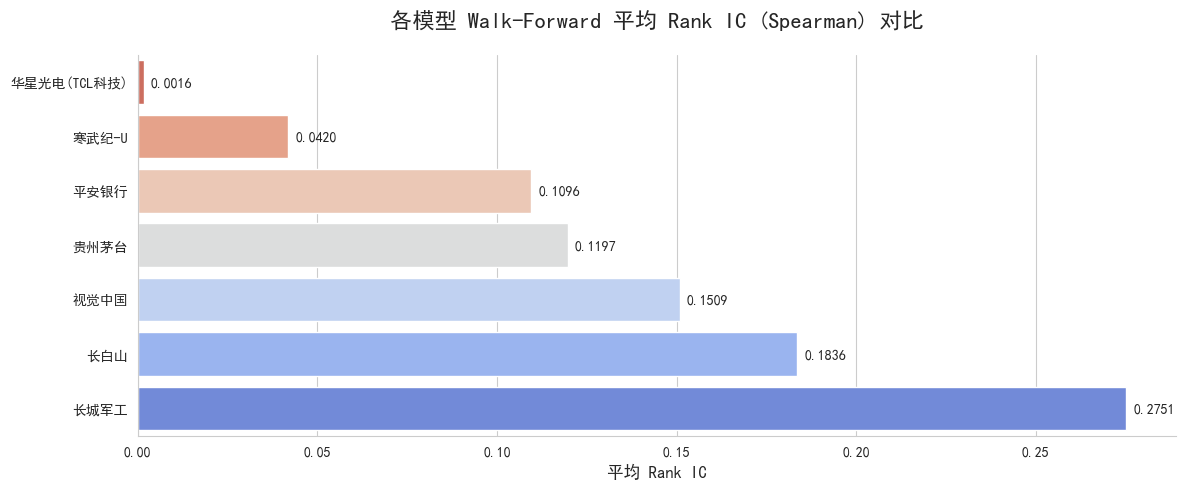

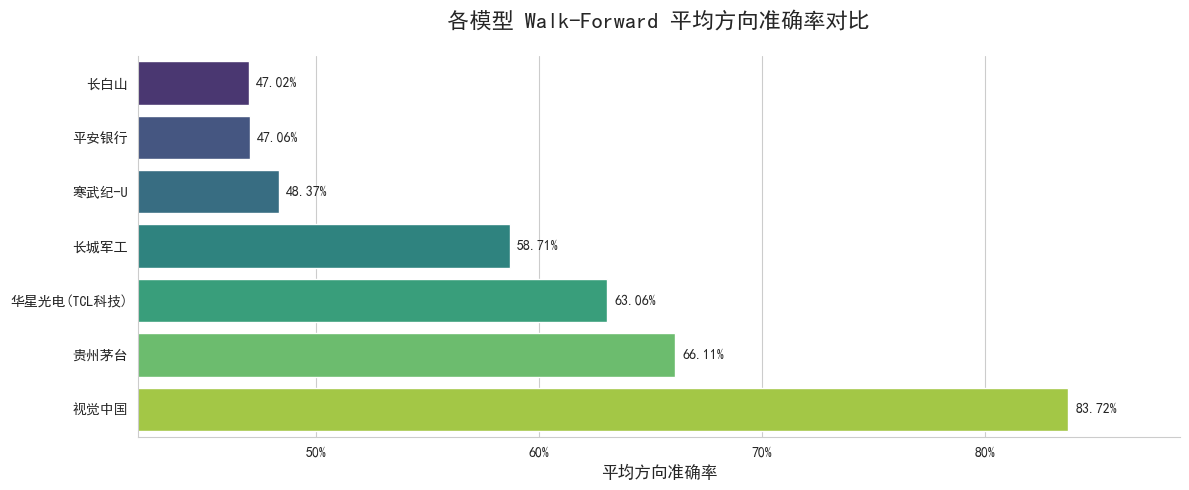

In [5]:
def load_all_metadata(model_dir: Path, config_data: dict) -> pd.DataFrame:
    all_metrics = []
    for file in list(model_dir.glob('**/metadata.json')):
        try:
            with open(file, 'r', encoding='utf-8') as f: meta = json.load(f)
            ticker = meta.get("build_info", {}).get("ticker", "N/A")
            keyword = next((s.get("keyword", ticker) for s in config_data.get("stocks_to_process", []) if s.get("ticker") == ticker), ticker)
            summary = meta.get("walk_forward_validation_summary", {})
            if not summary or not isinstance(summary, dict): continue
            median_metrics = summary.get("q_0.5", {})
            
            # --- 关键修正区域 ---
            all_metrics.append({
                "模型名称": keyword, "Ticker": ticker,
                "平均方向准确率 (q=0.5)": median_metrics.get("avg_accuracy"), # <-- 将 "accuracy" 改为 "avg_accuracy"
                "平均Rank IC (q=0.5)": median_metrics.get("avg_rank_ic"),
                "平均损失 (q=0.5)": median_metrics.get("avg_loss"),
                "覆盖率 (q=0.05)": summary.get("q_0.05", {}).get("avg_coverage"),
                "覆盖率 (q=0.95)": summary.get("q_0.95", {}).get("avg_coverage"),
                "模型版本": file.parent.name
            })
            # --- 修正结束 ---

        except (json.JSONDecodeError, KeyError) as e: print(f"解析文件 {file} 时出错: {e}")
    return pd.DataFrame(all_metrics).sort_values("平均Rank IC (q=0.5)", ascending=False).reset_index(drop=True) if all_metrics else pd.DataFrame()

if config:
    results_df = load_all_metadata(Path(config.get("global_settings", {}).get("model_dir", "models")), config)
    print("模型性能数据加载完成。")
else:
    results_df = pd.DataFrame()

if not results_df.empty:
    display(results_df.style.background_gradient(
        cmap='viridis', subset=['平均Rank IC (q=0.5)', '平均方向准确率 (q=0.5)']
    ).format({
        '平均方向准确率 (q=0.5)': '{:.2%}',
        '平均Rank IC (q=0.5)': '{:.4f}',
        '平均损失 (q=0.5)': '{:.6f}',
        '覆盖率 (q=0.05)': '{:.2%}',
        '覆盖率 (q=0.95)': '{:.2%}'
    }, na_rep="-").set_caption("模型性能对比"))
else:
    print("没有可供展示的性能数据。")

# 可视化 Rank IC
if not results_df.empty and '平均Rank IC (q=0.5)' in results_df.columns and results_df['平均Rank IC (q=0.5)'].notna().any():
    plt.figure(figsize=(12, max(5, len(results_df) * 0.6)))
    plot_df_ic = results_df.dropna(subset=['平均Rank IC (q=0.5)']).sort_values('平均Rank IC (q=0.5)', ascending=True)
    ax = sns.barplot(x='平均Rank IC (q=0.5)', y='模型名称', data=plot_df_ic, palette='coolwarm_r')
    ax.set_title('各模型 Walk-Forward 平均 Rank IC (Spearman) 对比', fontsize=16, pad=20)
    ax.set_xlabel('平均 Rank IC', fontsize=12); ax.set_ylabel('')
    for p in ax.patches:
        width = p.get_width()
        ax.annotate(f'{width:.4f}', xy=(width, p.get_y() + p.get_height() / 2.), xytext=(5 if width >= 0 else -10, 0), textcoords='offset points', ha="left" if width >= 0 else "right", va="center", fontsize=10)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    plt.tight_layout(); plt.show()
else:
    print("没有足够的 Rank IC 数据进行可视化。")

# 可视化准确率
if not results_df.empty and '平均方向准确率 (q=0.5)' in results_df.columns and results_df['平均方向准确率 (q=0.5)'].notna().any():
    plt.figure(figsize=(12, max(5, len(results_df) * 0.6)))
    plot_df_acc = results_df.dropna(subset=['平均方向准确率 (q=0.5)']).sort_values('平均方向准确率 (q=0.5)', ascending=True)
    ax = sns.barplot(x='平均方向准确率 (q=0.5)', y='模型名称', data=plot_df_acc, palette='viridis')
    ax.set_title('各模型 Walk-Forward 平均方向准确率对比', fontsize=16, pad=20)
    ax.set_xlabel('平均方向准确率', fontsize=12); ax.set_ylabel('')
    ax.set_xlim(left=max(0.4, plot_df_acc['平均方向准确率 (q=0.5)'].min() - 0.05), right=min(1, plot_df_acc['平均方向准确率 (q=0.5)'].max() + 0.05))
    ax.xaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format))
    for p in ax.patches:
        width = p.get_width()
        ax.annotate(f'{width:.2%}', xy=(width, p.get_y() + p.get_height() / 2.), xytext=(5, 0), textcoords='offset points', ha="left", va="center", fontsize=10)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    plt.tight_layout(); plt.show()
else:
    print("没有足够的方向准确率数据进行可视化。")